In [1]:
# Import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
import statsmodels.api as sm
from ggplot import *
import os
from sklearn.model_selection import train_test_split, KFold

% matplotlib inline

C:\Users\John\Anaconda\envs\py3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\John\Anaconda\envs\py3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\John\Anaconda\envs\py3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


In [2]:
#Set up the NBA teams and the years
years = ['16_17', '17_18']

nba_teams = ['atl','bos','brk','cho','chi','cle','dal','den','det','gsw',
             'hou','ind','lac','lal','mem','mia','mil','min','nop','nyk',
             'okc','orl','phi','pho','por','sac','sas','tor','uta','was']

In [3]:
# All data gathered from basketball-reference.com
df_dict = {}
for year in years:
    for team in nba_teams:
        # This loop constructs a dataframe and then adds it to a dictionary
        # The key is the team and year and the value is the dataframe
        df_dict[team+year] = pd.read_csv('team_data/' + team+year + '.csv', header = 1)
        df_dict[team+year].rename(index=str, columns={'Unnamed: 3': 'H/A', 
                                             'Tm': 'PS', 'Opp.1': 'PA'},
                            inplace = True)
        # Clean the data by making it consistent
        col_dict = {}
        for col in list(df_dict[team+year]):
            col_dict[col] = col.replace('.1', '_Allowed')
        df_dict[team+year].rename(columns=col_dict, inplace = True)
        df_dict[team+year]['Tm'] = team
        df_dict[team+year]['H/A'].fillna('H', inplace = True)
        df_dict[team+year].replace('@', 'A', inplace = True)
        df_dict[team+year].Date = pd.to_datetime(df_dict[team+year].Date, 
                                            infer_datetime_format=True)
        df_dict[team+year]['H/A'] = df_dict[team+year]['H/A'].astype('category')
        df_dict[team+year]['W/L'] = df_dict[team+year]['W/L'].astype('category')
        df_dict[team+year].drop('Unnamed: 24', axis = 1, inplace = True)
        df_dict[team+year]['W/L.bool'] = np.where(df_dict[team+year]['W/L']=='W', 1, 0)
        df_dict[team+year]['Opp'] = df_dict[team+year]['Opp'].str.lower()
        # Effective field goal percentage is (FG + (0.5*3P))/FGA
        df_dict[team+year]['eFG%'] = (df_dict[team+year]['FG'] + (0.5 * df_dict[team+year]['3P'])) / df_dict[team+year]['FGA']
        # Turnover percentage is (TOV/(FGA + (0.44 * FTA) + TOV))
        df_dict[team+year]['TOV%'] = df_dict[team+year]['TOV'] / (df_dict[team+year]['FGA'] + (0.44 * df_dict[team+year]['FTA']) + df_dict[team+year]['TOV'])
        # Offensive rebounding percentage is (ORB/(ORB + (TRB_Allowed - ORB_Allowed))) i.e. opponents defensive rebounds
        df_dict[team+year]['ORB%'] = df_dict[team+year]['ORB'] / (df_dict[team+year]['ORB'] + (df_dict[team+year]['TRB_Allowed'] - df_dict[team+year]['ORB_Allowed']))
        # Defensive rebounding percentage is ((TRB - ORB)/(ORB_Allowed) + (TRB - ORB))
        df_dict[team+year]['DRB%'] = (df_dict[team+year]['TRB'] - df_dict[team+year]['ORB']) / (df_dict[team+year]['ORB_Allowed'] + (df_dict[team+year]['TRB'] - df_dict[team+year]['ORB']))
        df_dict[team+year]['eFG%_Allowed'] = (df_dict[team+year]['FG_Allowed'] + (0.5 * df_dict[team+year]['3P_Allowed'])) / df_dict[team+year]['FGA_Allowed']
        df_dict[team+year]['TOV%_Allowed'] = df_dict[team+year]['TOV_Allowed'] / (df_dict[team+year]['FGA_Allowed'] + (0.44 * df_dict[team+year]['FTA_Allowed']) + df_dict[team+year]['TOV_Allowed'])
        df_dict[team+year]['ORB%_Allowed'] = df_dict[team+year]['ORB_Allowed'] / (df_dict[team+year]['ORB_Allowed'] + (df_dict[team+year]['TRB'] - df_dict[team+year]['ORB']))
        df_dict[team+year]['DRB%_Allowed'] = (df_dict[team+year]['TRB_Allowed'] - df_dict[team+year]['ORB_Allowed']) / (df_dict[team+year]['ORB'] + (df_dict[team+year]['TRB_Allowed'] - df_dict[team+year]['ORB_Allowed']))
        # Steal and block percentage is ((STL + BLK)/(FGA + (0.44 * FTA) + TOV))
        df_dict[team+year]['STLBLK%'] = (df_dict[team+year]['STL'] + df_dict[team+year]['BLK'])/(df_dict[team+year]['FGA_Allowed'] + (0.44 * df_dict[team+year]['FTA_Allowed']) + df_dict[team+year]['TOV_Allowed'])
        # Possession estimates are (FGA + (0.44 * FTA) + TOV)
        df_dict[team+year]['EstPos'] = (df_dict[team+year]['FGA'] + (0.44 * df_dict[team+year]['FTA']) + df_dict[team+year]['TOV'])
        df_dict[team+year]['EstPos_Allowed'] = (df_dict[team+year]['FGA_Allowed'] + (0.44 * df_dict[team+year]['FTA_Allowed']) + df_dict[team+year]['TOV_Allowed'])
        df_dict[team+year]['PperPos'] = df_dict[team+year]['PS']/df_dict[team+year]['EstPos']
        df_dict[team+year]['PperPos_Allowed'] = df_dict[team+year]['PA']/df_dict[team+year]['EstPos_Allowed']

In [4]:
for year in years:
    for team in nba_teams:
        # Offensive rating is ((0.45 * eFG%) - (0.25 * TOV%) + (0.15 * ORB%) + (0.15 * ((FTA/EstPos) + FT%))
        df_dict[team+year]['ORt'] = ((0.45 * df_dict[team+year]['eFG%']) - (0.25 * df_dict[team+year]['TOV%']) + (0.15 * df_dict[team+year]['ORB%']) + (0.15 * ((df_dict[team+year]['FTA']/df_dict[team+year]['EstPos']) + df_dict[team+year]['FT%']))) * 100.0
        # Defensive rating is ((0.4 * eFG%_Allowed) - (0.2 * STLBLK%) + (0.2 * ORB%_Allowed) + (0.2 * (FTA_Allowed/EstPos_Allowed)))
        df_dict[team+year]['DRt'] = ((0.4 * df_dict[team+year]['eFG%_Allowed']) - (0.2 * df_dict[team+year]['STLBLK%']) + (0.2 * df_dict[team+year]['ORB%_Allowed']) + (0.2 * (df_dict[team+year]['FTA_Allowed'])/(df_dict[team+year]['EstPos_Allowed']))) * 100.0

In [5]:
for year in years:
    for team in nba_teams:
        for stat in ['ORt','DRt']:
            # Created the expanding average used in the model
            df_dict[team+year][stat + '_RAvg'] = df_dict[team+year][stat].expanding(1).mean().shift(1)

In [6]:
# The loop below merges the opponent's stats for each game
# It slowly builds a new dataframe for each team
for year in years:
    for team1 in nba_teams:
        df_dict[team1+year +'_full'] = pd.DataFrame()
        for team2 in nba_teams:
            df_dict[team1+year + '_full'] = pd.concat([df_dict[team1+year + '_full'],df_dict[team1+year].merge(df_dict[team2+year][['Date','Tm','Opp',
                                                                                                    'ORt_RAvg','DRt_RAvg']], 
                                                                                        how='inner', left_on=['Date','Tm','Opp'],
                                                                                        right_on=['Date','Opp','Tm'], 
                                                                                        suffixes=('','_Opp'))])
        df_dict[team1+year + '_full'].sort_values(by=['G'], inplace=True)
        df_dict[team1+year + '_full'].dropna(how='any', inplace=True)

In [7]:
# Create a reduced dataframe
for year in years:
    for team in nba_teams:
        df_dict[team+year + '_red'] = df_dict[team+year + '_full'][['G','Date','H/A','Tm','Opp','PS','PA','W/L.bool','ORt_RAvg','DRt_RAvg','ORt_RAvg_Opp',
                                                     'DRt_RAvg_Opp']]

In [8]:
#Create a season-long dataframe
df_17_18 = pd.DataFrame()
df_16_17 = pd.DataFrame()
for team in nba_teams:
    df_17_18 = df_17_18.append(df_dict[team +'17_18' + '_red'], ignore_index = True)

for team in nba_teams:
    df_16_17 = df_16_17.append(df_dict[team +'16_17' + '_red'], ignore_index = True)

In [9]:
# Only want home games
df_17_18 = df_17_18[df_17_18['H/A'] == 'H']
df_16_17 = df_16_17[df_16_17['H/A'] == 'H']

In [10]:
df_17_18.head()

,G,Date,H/A,Tm,Opp,PS,PA,W/L.bool,ORt_RAvg,DRt_RAvg,ORt_RAvg_Opp,DRt_RAvg_Opp
4,6,2017-10-27,H,atl,den,100,105,0,35.947658,27.739018,35.973336,26.873092
5,7,2017-10-29,H,atl,mil,106,117,0,36.573891,27.548765,37.348237,27.797285
7,9,2017-11-03,H,atl,hou,104,119,0,36.592765,27.968559,38.305475,25.615328
9,11,2017-11-06,H,atl,bos,107,110,0,36.963003,27.949629,38.148340,23.708537
13,15,2017-11-15,H,atl,sac,126,80,1,37.038637,28.555603,34.894560,28.566318


In [11]:
df_16_17.head()

,G,Date,H/A,Tm,Opp,PS,PA,W/L.bool,ORt_RAvg,DRt_RAvg,ORt_RAvg_Opp,DRt_RAvg_Opp
1,3,2016-10-31,H,atl,sac,106,95,1,38.005619,19.616001,38.575424,29.430573
2,4,2016-11-02,H,atl,lal,116,123,0,38.591027,21.746482,37.009258,28.489916
4,6,2016-11-05,H,atl,hou,112,97,1,37.641625,24.154762,39.490646,28.123758
6,8,2016-11-09,H,atl,chi,115,107,1,38.027844,24.356713,40.252515,25.397964
7,9,2016-11-12,H,atl,phi,117,96,1,38.501483,24.409702,33.878340,26.286892


In [12]:
full_df = pd.concat([df_16_17, df_17_18])

In [13]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2043 entries, 1 to 1656
Data columns (total 12 columns):
G               2043 non-null int64
Date            2043 non-null datetime64[ns]
H/A             2043 non-null category
Tm              2043 non-null object
Opp             2043 non-null object
PS              2043 non-null int64
PA              2043 non-null int64
W/L.bool        2043 non-null int32
ORt_RAvg        2043 non-null float64
DRt_RAvg        2043 non-null float64
ORt_RAvg_Opp    2043 non-null float64
DRt_RAvg_Opp    2043 non-null float64
dtypes: category(1), datetime64[ns](1), float64(4), int32(1), int64(3), object(2)
memory usage: 185.6+ KB


In [14]:
full_df.sort_values(by=['Date'], inplace = True)
full_df.reset_index(inplace = True)
full_df.drop('index', axis = 1, inplace = True)

In [15]:
full_df.head()

,G,Date,H/A,Tm,Opp,PS,PA,W/L.bool,ORt_RAvg,DRt_RAvg,ORt_RAvg_Opp,DRt_RAvg_Opp
0,2,2016-10-27,H,sac,sas,94,102,0,39.805115,27.799446,44.705107,24.647354
1,2,2016-10-28,H,uta,lal,96,89,1,41.367910,29.254944,41.785669,29.680100
2,2,2016-10-28,H,tor,cle,91,94,0,40.681315,23.799275,39.275644,22.214510
3,2,2016-10-28,H,brk,ind,103,94,1,39.106817,31.106332,40.076865,24.630514
4,2,2016-10-28,H,det,orl,108,82,1,34.129964,29.680929,36.200584,28.390347


In [16]:
# Set up and run the model
full_df['intercept'] = 1

X = full_df[['intercept','ORt_RAvg','DRt_RAvg','DRt_RAvg_Opp','ORt_RAvg_Opp']]
y = full_df['W/L.bool']

log = sm.Logit(y, X)
res = log.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.644928
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               W/L.bool   No. Observations:                 2043
Model:                          Logit   Df Residuals:                     2038
Method:                           MLE   Df Model:                            4
Date:                Thu, 22 Feb 2018   Pseudo R-squ.:                 0.04969
Time:                        22:15:16   Log-Likelihood:                -1317.6
converged:                       True   LL-Null:                       -1386.5
                                        LLR p-value:                 8.358e-29
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -3.6995      2.387     -1.550      0.121      -8.379       0.980
ORt_RAvg         0.2683      0.034      7.900      0.000       0.202       0.335
DRt_RAvg        -0.1101      0.042     -2.613      0.009      -0.193      -0.028
DRt_RAvg_Opp     0.1915      0.042      4.549      0.000       0.109       0.274
ORt_RAvg_Opp    -0.2186      0.034     -6.449      0.000      -0.285      -0.152
================================================================================
"""

In [17]:
cm = res.pred_table(.5)
cm

array([[  298.,   550.],
       [  191.,  1004.]])

In [18]:
print('The accuracy is: {:.2f}%.'.format(((cm[0][0] + cm[1][1])/2043) * 100.0))
print('The precision is: {:.2f}%.'.format((cm[1][1]/(cm[0][1] + cm[1][1])) * 100.0))
print('The recall is: {:.2f}%.'.format((cm[1][1]/(cm[1][0] + cm[1][1])) * 100.0))

The accuracy is: 63.73%.
The precision is: 64.61%.
The recall is: 84.02%.


In [19]:
kf = KFold(n_splits=10, shuffle=True)

In [20]:
# Run a 10-fold cross-validation to confirm the accuracy
accuracies = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    log_kf = sm.Logit(y_train, X_train)
    res_kf = log_kf.fit()
    ypreds = res_kf.predict(X_test)
    predictions = []
    for prob in ypreds:
        if prob > 0.5:
            predictions.append(1)
        else:
            predictions.append(0)
    accuracy = (predictions == y_test).mean()
    accuracies.append(accuracy)
    

Optimization terminated successfully.
         Current function value: 0.646253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648893
  

In [21]:
accuracies = np.asarray(accuracies)
print('Mean accuracy from the cross-validation was {:.2f}%.'.format(accuracies.mean() * 100.0))

Mean accuracy from the cross-validation was 63.39%.


# Visualizations

In [22]:
ort_avg16 = []
drt_avg16 = []
for year in ['16_17']:
    for team in nba_teams:
        ort_avg16.append(df_dict[team+year]['ORt'].mean())
        drt_avg16.append(df_dict[team+year]['DRt'].mean())

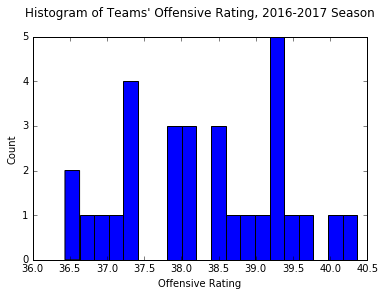

In [23]:
plt.hist(ort_avg16, bins=20, align='mid');
plt.xlabel('Offensive Rating')
plt.ylabel('Count')
plt.title("Histogram of Teams' Offensive Rating, 2016-2017 Season\n");

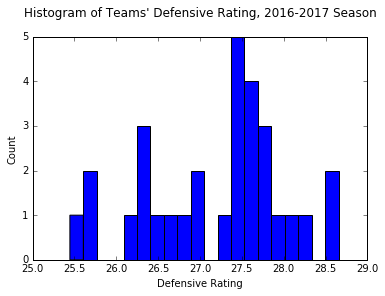

In [24]:
plt.hist(drt_avg16, bins=20, align='mid');
plt.xlabel('Defensive Rating')
plt.ylabel('Count')
plt.title("Histogram of Teams' Defensive Rating, 2016-2017 Season\n");

In [25]:
ort_avg17 = []
drt_avg17 = []
for year in ['17_18']:
    for team in nba_teams:
        ort_avg17.append(df_dict[team+year]['ORt'].mean())
        drt_avg17.append(df_dict[team+year]['DRt'].mean())

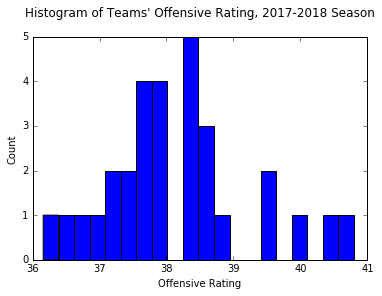

In [26]:
plt.hist(ort_avg17, bins=20, align='mid');
plt.xlabel('Offensive Rating')
plt.ylabel('Count')
plt.title("Histogram of Teams' Offensive Rating, 2017-2018 Season\n");

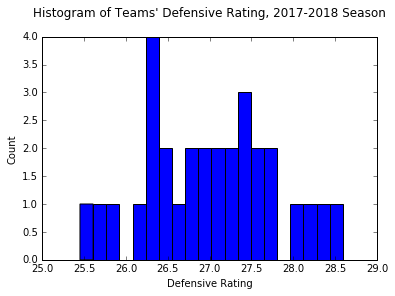

In [27]:
plt.hist(drt_avg17, bins=20, align='mid');
plt.xlabel('Defensive Rating')
plt.ylabel('Count')
plt.title("Histogram of Teams' Defensive Rating, 2017-2018 Season\n");

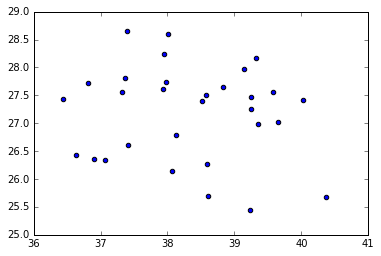

In [28]:
plt.scatter(ort_avg16, drt_avg16);

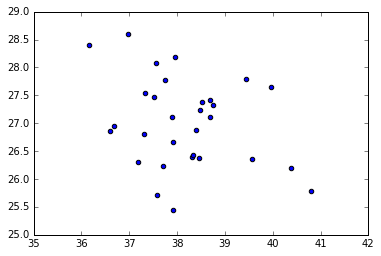

In [29]:
plt.scatter(ort_avg17, drt_avg17);

In [30]:
win_dict = {}
for year in ['16_17']:
    for team in nba_teams:
        sub_dict = {}
        sub_dict['wins'] = df_dict[team+year]['W/L.bool'].sum()
        sub_dict['ORt'] = df_dict[team+year]['ORt'].mean()
        sub_dict['DRt'] = df_dict[team+year]['DRt'].mean()
        win_dict[team] = sub_dict

In [31]:
visual_df = pd.DataFrame.from_dict(win_dict, orient='index')

In [32]:
visual_df.index.name = 'team'

In [33]:
visual_df['team'] = visual_df.index

In [34]:
plot = ggplot(visual_df, aes(x='ORt', y='DRt', size='wins')) + \
    geom_point() + \
    geom_hline(y=[visual_df['DRt'].mean()], size = 1, color='black') + \
    geom_vline(x=[visual_df['ORt'].mean()], size = 1, color='black') + \
    labs(title='Season Long Offensive and Defensive Rating for the 2016-2017 NBA Season', y='Defensive Rating', x='Offensive Rating')

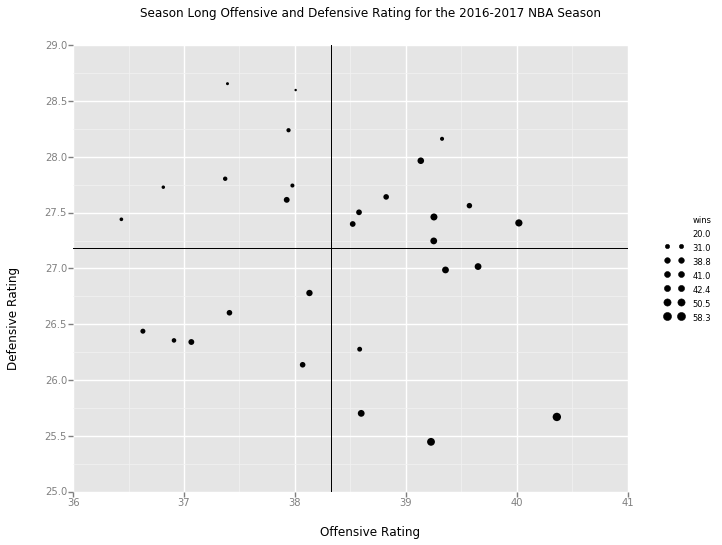

<ggplot: (138485530344)>

In [35]:
plot

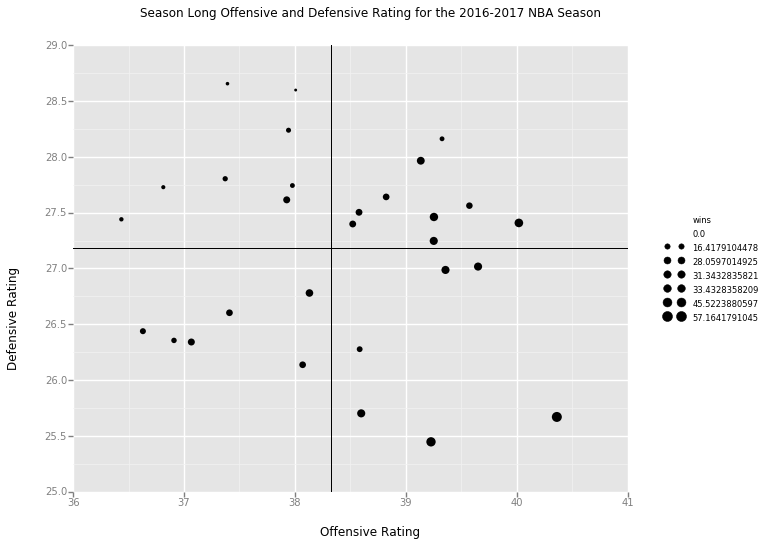

In [36]:
plot.save(filename='winvisualization.png',dpi=500)

In [37]:
win_dict2 = {}
for year in ['17_18']:
    for team in nba_teams:
        sub_dict = {}
        sub_dict['wins'] = df_dict[team+year]['W/L.bool'].sum()
        sub_dict['ORt'] = df_dict[team+year]['ORt'].mean()
        sub_dict['DRt'] = df_dict[team+year]['DRt'].mean()
        win_dict2[team] = sub_dict
        
visual_df2 = pd.DataFrame.from_dict(win_dict2, orient='index')
visual_df2.index.name = 'team'
visual_df2['team'] = visual_df2.index

In [38]:
plot2 = ggplot(visual_df2, aes(x='ORt', y='DRt', size='wins')) + \
    geom_point() + \
    geom_hline(y=[visual_df2['DRt'].mean()], size = 1, color='black') + \
    geom_vline(x=[visual_df2['ORt'].mean()], size = 1, color='black') + \
    labs(title='Season Long Offensive and Defensive Rating for the 2017-2018 NBA Season', y='Defensive Rating', x='Offensive Rating')

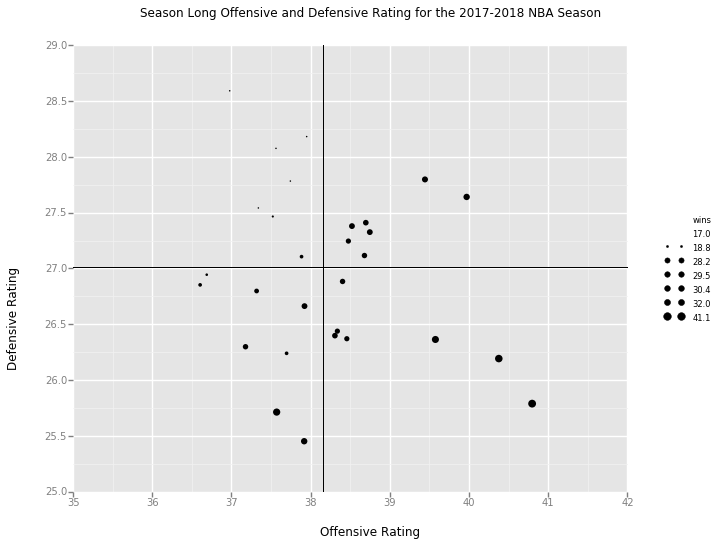

<ggplot: (138485939383)>

In [39]:
plot2